In [1]:
# Import Libraries
import sqlite3
import pandas as pd
import numpy as np
#!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [3]:
#IMPORT & LOAD DATA
datacustomer = pd.read_csv ("D:/Data/data.csv",encoding = "ISO-8859-1") #Encoded as this dataset contains West Europe countries retail transactions
datacustomer.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


# Data Preparation

In [4]:
datacustomer.shape #Melihat jumlah data

(541909, 8)

In [5]:
datacustomer.select_dtypes(include=['object']).columns

Index(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country'], dtype='object')

In [6]:
datacustomer.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

# Data Cleaning & Exploratory Analysis

In [7]:
#will remove the duplicate entries in the datset - 5268
print (datacustomer.duplicated().sum())    
datacustomer.drop_duplicates(inplace = True)
datacustomer.shape   #(536641, 8)

5268


(536641, 8)

In [9]:
#Removing missing values based on Description.
#datacustomer.dropna(axis = 0, subset =['CustomerID'], inplace = True)
#datacustomer.shape #(406829, 8)

datacustomer = datacustomer[pd.notnull(datacustomer['Description'])]
datacustomer.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133583
Country             0
dtype: int64

In [13]:
#Removing Cancelled orders
#datacustomer = datacustomer[(datacustomer.InvoiceNo).apply(lambda x:( 'C' not in x))]
#datacustomer.shape    #(392732, 8)

cancel = datacustomer[datacustomer.InvoiceNo.str.match('^[a-zA-Z]')].index
datacustomer.drop(cancel, axis=0, inplace=True)

special_code = datacustomer[datacustomer['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
clean_df = datacustomer[~datacustomer['StockCode'].isin([special_code])]

In [12]:
#df_customerid_groups=datacustomer.groupby("CustomerID")
#print (len((df_customerid_groups.groups))) #length of dictionary - 4339

In [13]:
# Drop sku and brand 
#datacustomer.drop('StockCode', axis=1, inplace=True)
#datacustomer.drop('Quantity', axis=1, inplace=True)
#datacustomer.drop('InvoiceDate', axis=1, inplace=True)
#datacustomer.drop('UnitPrice', axis=1, inplace=True)
#datacustomer.drop('CustomerID', axis=1, inplace=True)
#datacustomer.drop('Country', axis=1, inplace=True)


# Building a recommendation system

Now the data will be grouped by order number so all items purchased in the same transaction are in a list together. The length of the list should match the count of unique order numbers 

In [14]:
# Combine items into lists by Invoice number
grouped = datacustomer.groupby('InvoiceNo')['Description'].apply(list)
grouped.head()

InvoiceNo
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
Name: Description, dtype: object

In [15]:
# Check shape of list 
grouped.shape

(20607,)

In [16]:
#We will filter out orders with less than 10 items to make our data more relevant for finding items that are purchased together.
#Filter out small orders
filtered_group = [x for x in grouped if len(x)>=10 ]

# Sample first few large orders
filtered_group[:3]

[['ASSORTED COLOUR BIRD ORNAMENT',
  "POPPY'S PLAYHOUSE BEDROOM ",
  "POPPY'S PLAYHOUSE KITCHEN",
  'FELTCRAFT PRINCESS CHARLOTTE DOLL',
  'IVORY KNITTED MUG COSY ',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  'BOX OF VINTAGE ALPHABET BLOCKS',
  'HOME BUILDING BLOCK WORD',
  'LOVE BUILDING BLOCK WORD',
  'RECIPE BOX WITH METAL HEART',
  'DOORMAT NEW ENGLAND'],
 ['ALARM CLOCK BAKELIKE PINK',
  'ALARM CLOCK BAKELIKE RED ',
  'ALARM CLOCK BAKELIKE GREEN',
  'PANDA AND BUNNIES STICKER SHEET',
  'STARS GIFT TAPE ',
  'INFLATABLE POLITICAL GLOBE ',
  'VINTAGE HEADS AND TAILS CARD GAME ',
  'SET/2 RED RETROSPOT TEA TOWELS ',
  'ROUND SNACK BOXES SET OF4 WOODLAND ',
  'SPACEBOY LUNCH BOX ',
  'LUNCH BOX I LOVE LONDON',
  'CIRCUS PARADE LUNCH BOX ',
  'CHARLOTTE BAG DOLLY GIRL DESIGN',
  'RED TOADSTOOL LED NIGHT LIGHT',
  ' SET 2 TEA TOWELS I LOVE LONDON ',
  'VINTAGE SEASIDE JIGSAW PUZZLES',
  'MINI JIGSAW CIRCUS PARADE ',
  'MINI JIGSAW SPACEBOY',
  'MINI PAIN

Now the data can be one-hot encoded using the MLxtend library

In [17]:
# One-hot encode data in pandas dataframe
te = TransactionEncoder()
te_ary = te.fit(filtered_group).transform(filtered_group)
transaction_group = pd.DataFrame(te_ary, columns=te.columns_)
transaction_group.head()

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Find itemsets that are in at least 1% of our data:

In [30]:
# Find items with minimal support using apriori algorithm to show which have any possible relationship
#apriori(df, min_support=0.6)
#apriori(transaction_group, min_support=0.6)
#apriori(transaction_group, min_support=0.6, use_colnames=True)
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

apriori(transaction_group, min_support=0.1, use_colnames=False, max_len=None, verbose=0, low_memory=False)

,support,itemsets
0,0.144073,(1788)
1,0.115013,(1974)
2,0.113556,(2381)
3,0.130271,(2818)
4,0.151127,(3802)


To remove any orders with only 1 item purchased, we'll create a column with the number of items in each order and then filter out single-item transactions.

In [21]:
# Find frequent item sets and and number of items in each order
freq_itemsets = apriori(transaction_group, min_support=0.03, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x : len(x))
freq_itemsets.head()

,support,itemsets,length
0,0.034351,(3 STRIPEY MICE FELTCRAFT),1
1,0.035807,(4 TRADITIONAL SPINNING TOPS),1
2,0.070311,(6 RIBBONS RUSTIC CHARM),1
3,0.033124,(60 CAKE CASES DOLLY GIRL DESIGN),1
4,0.045238,(60 CAKE CASES VINTAGE CHRISTMAS),1


In [25]:
#Filter out single-item orders 
freq_itemsets[ (freq_itemsets['length'] > 1) &
             (freq_itemsets['support'] >= 0.05) ]

,support,itemsets,length
292,0.054209,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",2
301,0.059960,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",2
312,0.050836,"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",2
314,0.053443,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)",2


## Create Recommendations

Now we can generate a dataframe of association rules and their corresponding metrics. We will focus on the support, lift, and confidence of each association. This will ensure that the associations our recommendations will be based on occur at a relative frequency (support) that is higher than expected with random associations (lift) to some degree of confidence.

In [26]:
# Generate association rules to make recommendations using lift metric to choose items that are purchased together 
# more often than expected
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
rules = association_rules(freq_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.097684,0.061340,0.033814,0.346154,5.643173,0.027822,1.435597
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.061340,0.097684,0.033814,0.551250,5.643173,0.027822,2.010731
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.069238,0.056740,0.030593,0.441860,7.787492,0.026665,1.690008
3,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.056740,0.069238,0.030593,0.539189,7.787492,0.026665,2.019836
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.074375,0.069238,0.045468,0.611340,8.829567,0.040319,2.394799


In [27]:
# Filter items and save
saved_recs = rules[ (rules['lift'] >= 6) &
     rules['confidence'] >= 0.8]

# Check saved dataframe
saved_recs.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
156,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.042401,0.070618,0.038261,0.902351,12.777915,0.035267,9.517560
157,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.044088,0.074375,0.038261,0.867826,11.668235,0.034982,7.003083
28,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.052599,0.070618,0.044088,0.838192,11.869387,0.040374,5.743748
142,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.052599,0.074375,0.042401,0.806122,10.838607,0.038489,4.774276
33,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.070618,0.074375,0.054209,0.767644,10.321249,0.048957,3.983647
32,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.074375,0.070618,0.054209,0.728866,10.321249,0.048957,3.427759
159,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.052599,0.054209,0.038261,0.727405,13.418415,0.035410,3.469584
26,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.054900,0.065864,0.039871,0.726257,11.026593,0.036255,3.412456
11,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.054823,0.075525,0.039258,0.716084,9.481387,0.035117,3.256155
158,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.054209,0.052599,0.038261,0.705799,13.418415,0.035410,3.220251


In [46]:
saved_recs.shape

(52, 9)

In [45]:
# Save Recs to csv
saved_recs.to_csv('recommendations.csv', index=False)

In [33]:
import matplotlib.pyplot as plt

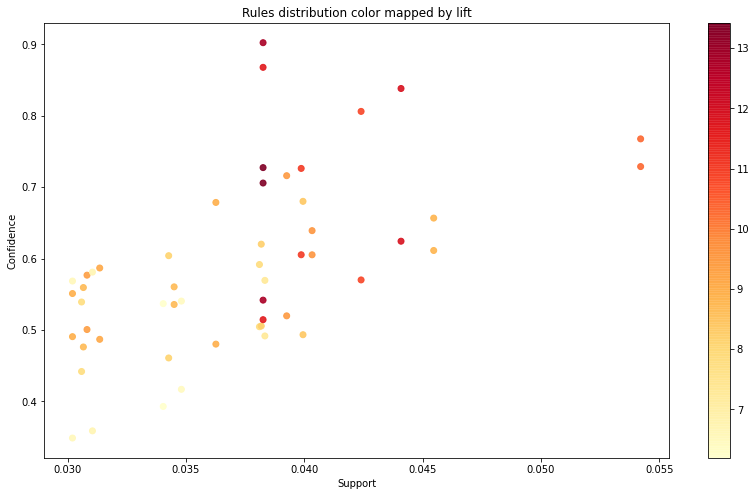

In [34]:
plt.figure(figsize=(14, 8))
plt.scatter(saved_recs['support'], saved_recs['confidence'], c=saved_recs['lift'], alpha=0.9, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

In [36]:
import seaborn as sns

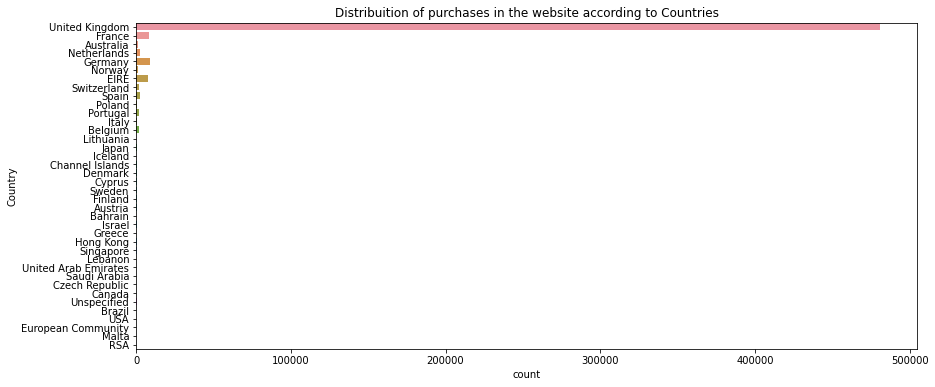

In [37]:
#The Majority of Buyer
country_set = clean_df[['Country', 'InvoiceNo']]
country_set = country_set.pivot_table(columns='Country', aggfunc='count')
country_set.transpose() 

plt.figure(figsize=(14,6))
plt.title('Distribuition of purchases in the website according to Countries');
sns.countplot(y='Country', data=clean_df);

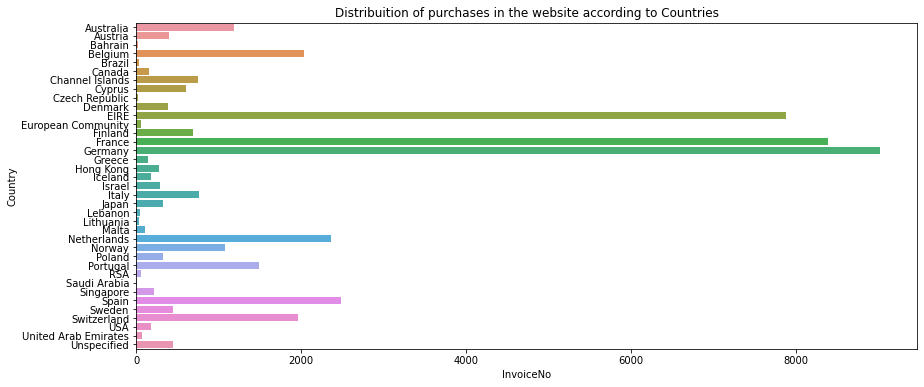

In [38]:
# Other buyers
df_others = country_set.T.drop('United Kingdom')
plt.figure(figsize=(14,6))
plt.title('Distribuition of purchases in the website according to Countries');

sns.barplot(y=df_others.index, x='InvoiceNo', data=df_others, orient='h');

In [41]:
import datetime

In [43]:
#Creating Datetime Table
data = clean_df.copy()
data['TotalRevenue'] = clean_df['Quantity']*clean_df['UnitPrice']
data['Month'] = clean_df['InvoiceDate'].apply(lambda x : x.split('/')[0]).astype(np.uint8)
data['Day'] = clean_df['InvoiceDate'].apply(lambda x : x.split('/')[1]).astype(np.uint8)
data['Year'] = clean_df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[0]).astype(np.uint16)
data['Time'] = clean_df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[1])
data['Hour']= data['Time'].apply(lambda x : x.split(':')[0]).astype(np.uint8)
data['datetime'] = list(map(lambda x : datetime.date(x[0],x[1],x[2]), data[['Year','Month','Day']].values) )
data['Day_week'] = list(map(lambda x :x.weekday(),data['datetime'].values)) # datetime.date(2017,12,25)
data['Day_week'] = data['Day_week'].map({0:'1Mon',1:'2Tue',2:'3Wed',3:'4Thur',4:'5Fri',5:'6Sat',6:'0Sun'})
data = data.sort_values('datetime').reset_index(drop=True)


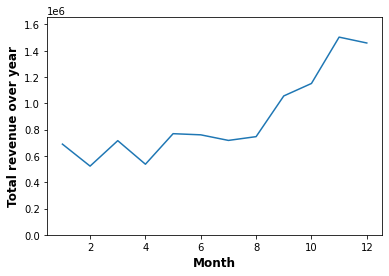

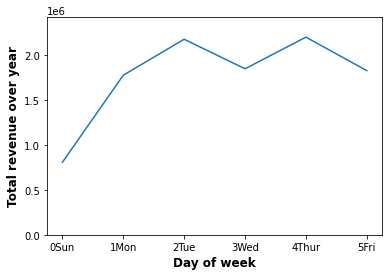

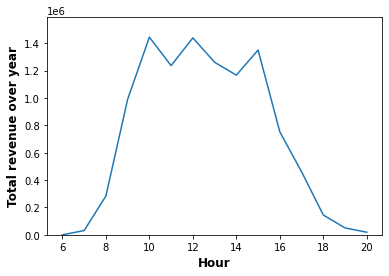

In [44]:
#Customer Behaviors of Purchasing

#Based on Month
temp  = data.groupby(['Month'])['TotalRevenue'].apply(np.sum)
plt.plot(temp);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Month',fontsize=12,fontweight='bold');
plt.show()

#Based on Day of Week
temp  = data.groupby(['Day_week'])['TotalRevenue'].apply(np.sum)
plt.plot(temp);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Day of week',fontsize=12,fontweight='bold');
plt.show()

#Based on Hours
temp  = data.groupby(['Hour'])['TotalRevenue'].apply(np.sum)
plt.plot(temp);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Hour',fontsize=12,fontweight='bold');
plt.show()
